# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [9]:
spl.hyperparameters

Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836)

In [10]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 144.21859932876725
eps: 0.25 --> VarE: 126.42378115656223
eps: 0.125 --> VarE: 23.81434272299488
eps: 0.0625 --> VarE: 4.169655771251212
eps: 0.03125 --> VarE: 1.1165045354177012


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.024545924742340214
samples: 243--> ESS: 0.010014289301261654
samples: 447--> ESS: 0.017693271326143168
samples: 739--> ESS: 0.020772523516066232


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.23963295154980524, 1.0619361375541467, 0.0, 0.2943474445210097]
 [0.23963295154980524, 1.0619361375541467, 0.5829972486413573, 4.088321038252194]
 [0.2397596041471353, 1.0347911413013045, 8.016406296600401, 7.818852247359863]
 [0.23977185557086056, 1.0035774118089784, 10.385843343290372, 10.847045381078411]
 [0.2397769617914019, 0.9723337172959587, 8.363912360516569, 13.168654699555221]
 [0.239768642619062, 0.9411004532660118, 6.255454196356756, 14.782645632008904]
 [0.23976459173474352, 0.9098544170637721, 4.128328362364211, 15.686140330236016]
 [0.2397786628335694, 0.8786523119617247, 2.0052855459515566, 15.887578698057116]
 [0.23975365753853825, 0.847553693510705, -0.09303938134690348, 15.388003736600984]
 [0.2397261053877554, 0.8164868778317521, -2.1915930552013396, 14.184047292371616]
 [0.2397044514397285, 0.7853494983190105, -3.373766222388717, 12.684518486514415]
 [0.2395549647767082, 0.7599371587220601, -1.4607350811150717, 14.20749077112545]
 [0.

In [11]:
#plt.plot(samples_mchmc.E[8000:end])

In [12]:
#mean(samples_mchmc.E[8000:end])

In [13]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [14]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

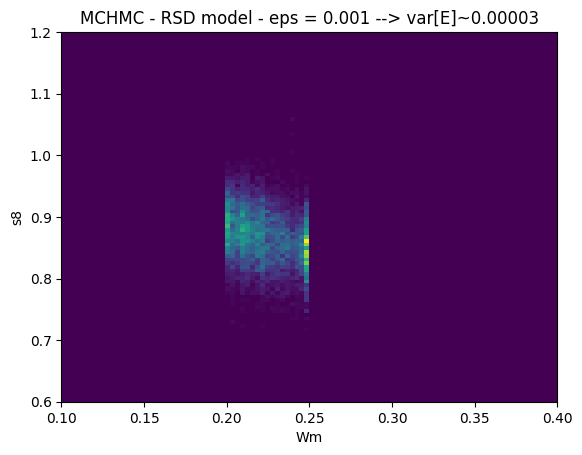

In [15]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [16]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 2121.248410781853
eps: 0.25 --> VarE: 64.8674276815265
eps: 0.125 --> VarE: 25.45832776951564
eps: 0.0625 --> VarE: 4.399514528340661
eps: 0.03125 --> VarE: 1.201978607294413
samples: 100--> ESS: 0.02505023612849312
samples: 243--> ESS: 0.009826823948880854
samples: 447--> ESS: 0.020337408313307978
samples: 739--> ESS: 0.02037780213726685


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.32 seconds
Compute duration  = 2.32 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2240    0.0147     0.0001    0.0014     32.3882    1.0116    ⋯
          σ8    0.8668    0.0414     0.0004    0.0012   2781.5801    1.0008    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2027    0.2104    0.2233    0.2365    0.2495
          σ8    0.7880    0.8380    0.8658    0.8950    0.9489


In [17]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.15 seconds
Compute duration  = 1.15 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2244    0.0140     0.0001    0.0013     36.8197    1.0363    ⋯
          σ8    0.8667    0.0403     0.0004    0.0011   2822.0987    1.0013    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2031    0.2122    0.2227    0.2367    0.2489
          σ8    0.7899    0.8392    0.8658    0.8939    0.9480


## Parallelization

In [25]:
using Distributed

In [26]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 100000, 2;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 2060.426620064039
eps: 0.25 --> VarE: 52.59502298458721
eps: 0.125 --> VarE: 26.153034598985414
eps: 0.0625 --> VarE: 3.389799499886054
eps: 0.03125 --> VarE: 0.6372720925127279
samples: 100--> ESS: 0.026308459964888762
samples: 243--> ESS: 0.009265536461304043
samples: 447--> ESS: 0.02127528215477795
samples: 739--> ESS: 0.014671012485412544


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
[ Info: number of chains: 2 smaller than number of threads: 4. Increase the number of chains to make full use of your threads.
chain 1:   2%|▋                                         |  ETA: 0:00:07
chain 2:   2%|█                                         |  ETA: 0:00:08
chain 1:   3%|█▎                                        |  ETA: 0:00:08
chain 2:   4%|█▌                                        |  ETA: 0:00:09
chain 1:   4%|█▋                                        |  ETA: 0:00:08
chain 2:   5%|██▏                                       |  ETA: 0:00:09
chain 1:   6%|██▎                                       |  ETA: 0:00:09
chain 2:   6%|██▌                                       |  ETA: 0:00:09
chain 1:   6%|██▊                                       |  ETA: 0:00:09
chain 2:   8%|███▏                                      |  ETA: 0:00:09
chain 1:   8%|███▍                                      |  ETA: 0:0

chain 1:  65%|███████████████████████████▎              |  ETA: 0:00:03
chain 2:  66%|███████████████████████████▊              |  ETA: 0:00:03
chain 2:  67%|████████████████████████████▏             |  ETA: 0:00:03
chain 1:  66%|███████████████████████████▉              |  ETA: 0:00:03
chain 2:  68%|████████████████████████████▌             |  ETA: 0:00:03
chain 1:  68%|████████████████████████████▍             |  ETA: 0:00:03
chain 2:  69%|█████████████████████████████             |  ETA: 0:00:03
chain 1:  68%|████████████████████████████▊             |  ETA: 0:00:03
chain 2:  70%|█████████████████████████████▍            |  ETA: 0:00:03
chain 1:  70%|█████████████████████████████▎            |  ETA: 0:00:03
chain 2:  71%|█████████████████████████████▉            |  ETA: 0:00:03
chain 1:  72%|██████████████████████████████            |  ETA: 0:00:03
chain 2:  72%|██████████████████████████████▌           |  ETA: 0:00:03
chain 2:  74%|██████████████████████████████▉           |  ETA: 

Chains MCMC chain (100000×4×2 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 2
Samples per chain = 100000
Wall duration     = 10.0 seconds
Compute duration  = 19.88 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          Ωm    0.2247    0.0142     0.0000    0.0005     805.5719    1.0003   ⋯
          σ8    0.8659    0.0401     0.0001    0.0004   56574.6861    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2015    0.2122    0.2247    0.2369    0.2487
          σ8    0.7879    0.8387    0.8657    0.8929    0.9447


In [27]:
samples

Chains MCMC chain (100000×4×2 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 2
Samples per chain = 100000
Wall duration     = 10.0 seconds
Compute duration  = 19.88 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          Ωm    0.2247    0.0142     0.0000    0.0005     805.5719    1.0003   ⋯
          σ8    0.8659    0.0401     0.0001    0.0004   56574.6861    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.2015    0.2122    0.2247    0.2369    0.2487
          σ8    0.7879    0.8387    0.8657    0.8929    0.9447


## NUTS

In [21]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:13┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be reje

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 6.39 seconds
Compute duration  = 6.39 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2245    0.0144     0.0001    0.0002   6328.4092    0.9999    ⋯
          σ8    0.8665    0.0390     0.0004    0.0005   5886.6100    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [22]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.239965  0.783786  14.093   3.0  1.0  …  1.0  0.0  0.996586  0.996586
 0.226233  0.884808  16.235   3.0  1.0     2.0  0.0  0.996586  0.996586
 0.236925  0.86737   16.0443  3.0  1.0     2.0  0.0  0.996586  0.996586
 0.237066  0.840793  15.9956  3.0  1.0     2.0  0.0  0.996586  0.996586
 0.233026  0.877303  16.1371  3.0  1.0     2.0  0.0  0.996586  0.996586
 0.245478  0.853844  15.1813  3.0  1.0  …  2.0  0.0  0.996586  0.996586
 0.214547  0.892774  16.0821  3.0  1.0     2.0  0.0  0.996586  0.996586
 0.222997  0.876046  16.3584  3.0  1.0     2.0  0.0  0.996586  0.996586
 0.225565  0.863147  16.3887  3.0  1.0     2.0  0.0  0.996586  

In [23]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

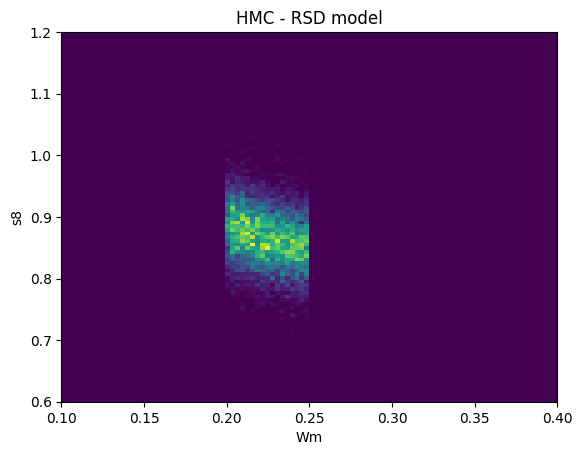

In [24]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");